In [2]:
from ase.io import read,write
import os
import matplotlib.pyplot as plt
import numpy as np


In [15]:
import os
from ase.io import read

def calculate_xy_area(atoms):
    """
    Calculate the xy area of the periodic cell from an ASE Atoms object.

    :param atoms: ASE Atoms object.
    :return: Area of the xy plane.
    """
    cell = atoms.get_cell()
    area = np.linalg.norm(np.cross(cell[0], cell[1]))
    return area

def extract_total_wall_time_in_seconds(filename):
    """
    Reads a Quantum ESPRESSO output file, extracts the wall time, and converts it to seconds.
    Handles '35m22.08s', '35m 22.08s', '1h 3m', and '1h18m' formats.

    :param filename: Path to the Quantum ESPRESSO output file
    :return: Total wall time in seconds, or None if not found
    """
    try:
        with open(filename, 'r') as file:
            for line in file:
                if 'PWSCF' in line and 'WALL' in line:  # Check for the specific line
                    parts = line.split()
                    wall_index = parts.index('WALL')
                    time_str = parts[wall_index - 1].replace('s', '')
                    hours, minutes, seconds = 0, 0, 0

                    # Check for and extract hours, if present
                    if 'h' in time_str:
                        if 'm' in time_str:
                            hours, rest = time_str.split('h')
                            hours = int(hours)
                            minutes, seconds = (rest.split('m') + ['0'])[:2]
                        else:
                            hours = int(time_str.rstrip('h'))
                    elif 'm' in time_str:
                        minutes, seconds = (time_str.split('m') + ['0'])[:2]
                    else:
                        seconds = time_str

                    # Convert minutes and seconds to integers
                    minutes = int(minutes) if minutes else 0
                    seconds = float(seconds) if seconds else 0

                    total_seconds = hours * 3600 + minutes * 60 + seconds
                    return total_seconds
        return None  # Return None if the line isn't found
    except Exception as e:
        print(f"Error reading file: {e}")
        return None
    
import numpy as np
from ase.io import read
from scipy.cluster.vq import kmeans, vq
import matplotlib.pyplot as plt
import os
from sklearn.cluster import DBSCAN

def add_allegro_number_array(ase_atom, eps=5, min_samples=1):
    """
    Assigns a number from 0 to 5 to each atom depending on its layer and position
    using DBSCAN clustering algorithm.

    :param ase_atom: ASE Atoms object with atom positions.
    :param eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    :param min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
    :return: A numpy array with assigned cluster numbers for each atom.
    """
    
    # Reshape the z-coordinates to fit the DBSCAN expected input
    z_coords = ase_atom.positions[:, 2].reshape(-1, 1)
    
    # Run DBSCAN clustering
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(z_coords)
    
    # Labels of clusters
    labels = db.labels_
    
    # Sort the unique labels, ignoring the noise if present
    unique_labels = np.unique(labels)
    unique_labels = unique_labels[unique_labels >= 0]  # Filter out noise (-1 label)
    
    # Sort labels based on the mean position of z-coordinates in each cluster
    mean_positions = [z_coords[labels == label].mean() for label in unique_labels]
    sorted_indices = np.argsort(mean_positions)
    
    # Map sorted labels to a range from 0 to n_types-1
    # label_mapping = {unique_label: i for i, unique_label in enumerate(sorted_indices)}
    label_mapping = np.array([0, 2, 1, 3, 5, 4])
    
    # Map the cluster labels to the sorted range
    allegro_number_array = np.array([label_mapping[label] if label != -1 else -1 for label in labels])

    return allegro_number_array

def extract_qe_data(directories, vals):
    """
    Extract forces, total energy, atomic positions, and atom types from QE output files in given directories.
    """
    data = {}
    for directory, vs in zip(directories, vals):
        output_file = os.path.join(directory, 'relax.out')
        if os.path.exists(output_file):
            atoms = read(output_file, format='espresso-out')
            forces = atoms.get_forces()
            total_energy = atoms.get_total_energy()
            positions = atoms.get_positions()
            volume = atoms.get_volume()
            wall_time = extract_total_wall_time_in_seconds(output_file)
            area = calculate_xy_area(atoms)
            cell = atoms.cell

            # Add atom types using the add_allegro_number_array function
            atom_types = add_allegro_number_array(atoms,eps = 0.5, min_samples=20)
            
            print(directory, wall_time)
            data[directory] = {
                'directory': directory,
                'conv_values': vs,
                'forces': forces,
                'total_energy': total_energy,
                'positions': positions,
                'atom_types': atom_types,  # Add atom types
                'wall_time': wall_time,
                'volume': volume,
                'area': area,
                'cell': cell
            }
        else:
            print(f"No output file found in {directory}")

    return data



def get_subdirectories(directory):
    """Get all subdirectories from the specified directory."""
    subdirectories = [os.path.join(directory, d) for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    return sorted(subdirectories)



# # List of directories to scan
# directories = ['/path/to/dir1', '/path/to/dir2', ...]  # Replace with actual directory paths

# # Extract data
# qe_data = extract_qe_data(directories)
# for dir, info in qe_data.items():
#     print(f"Directory: {dir}")
#     print("Forces:", info['forces'])
#     print("Total Energy:", info['total_energy'])
#     print("Positions:", info['positions'])
#     print("----------")

In [16]:
# Get subdirectories and print them
ecut_dirs = get_subdirectories('./1-ecut/')
degauss_dirs = get_subdirectories('./2-degauss/')
zbox_dirs = get_subdirectories('./3-zbox/')
econv_dirs = get_subdirectories('./4-econv/')
forc_conv_dirs = get_subdirectories('./5-forc_conv_thr/')
kpt_conv_dirs = get_subdirectories('./6-kpt')
ref_conv_dirs = get_subdirectories('./7-most_converged/')


print(ecut_dirs)

ecut_vals = [40,50,60,70,75,80,90,100,110,120]
degauss_vals = [1e-4,2e-4,3e-4,4e-4]
zbox_vals = [15,16,17,18,19, 20, 21, 22, 23, 25,26]
econv_vals = [1e-8,1e-9, 1e-10]
forc_conv_vals = [1e-3,1e-4]
kpt_conv_vals = [1,2,3]
ref_conv_vals = [0]

ecut_data = extract_qe_data(ecut_dirs,ecut_vals)
degauss_data = extract_qe_data(degauss_dirs, degauss_vals)
zbox_data = extract_qe_data(zbox_dirs, zbox_vals)
econv_data = extract_qe_data(econv_dirs, econv_vals)
forc_conv_data = extract_qe_data(forc_conv_dirs, forc_conv_vals)
kpt_conv_data = extract_qe_data(kpt_conv_dirs,kpt_conv_vals)
ref_conv_data = extract_qe_data(ref_conv_dirs,ref_conv_vals)






['./1-ecut/1-ecut40', './1-ecut/2-ecut50', './1-ecut/3-ecut60', './1-ecut/4-ecut70', './1-ecut/4.5-ecut75', './1-ecut/5-ecut80', './1-ecut/6-ecut90', './1-ecut/7-ecut100', './1-ecut/8-ecut110', './1-ecut/9-ecut120']


./1-ecut/1-ecut40 1340.72
./1-ecut/2-ecut50 1851.33
./1-ecut/3-ecut60 2094.61
./1-ecut/4-ecut70 3.48
./1-ecut/4.5-ecut75 2997.63
./1-ecut/5-ecut80 3148.07
./1-ecut/6-ecut90 180
./1-ecut/7-ecut100 4680
./1-ecut/8-ecut110 5220
./1-ecut/9-ecut120 6180
./2-degauss/1-degauss_0004 2242.55
./2-degauss/2-deguass_0003 2330.62
./2-degauss/3-degauss_0002 2217.93
./2-degauss/4-degauss_0001 2261.99
./3-zbox/1-z15 468.97
./3-zbox/2-z16 1732.1
./3-zbox/3-z17 1701.94
./3-zbox/4-z18 1820.3
./3-zbox/5-z19 2054.27
./3-zbox/6-z20 2122.08
./3-zbox/7-z21 1993.38
./3-zbox/8-z22 2115.36
./3-zbox/9-z23 9.58
./3-zbox/9a-z25 6360
./3-zbox/9b-z26 5820
./4-econv/1-e-8 2094.61
./4-econv/2-e-9 2276.24
./4-econv/3-e-10 2513.0
./5-forc_conv_thr/1-e-3 2094.61
./5-forc_conv_thr/2-e-4 3280.98
./6-kpt/1-k_1 1340.72
./6-kpt/2-k_2 6360
./6-kpt/3-k_3 6300
./7-most_converged/1-v1 4920


In [17]:
zbox_data.pop('./3-zbox/1-z15')

{'directory': './3-zbox/1-z15',
 'conv_values': 15,
 'forces': array([[-0.00096571, -0.0001211 ,  0.00703891],
        [-0.00394253, -0.00175709, -0.00124184],
        [ 0.00397184,  0.00461847,  0.00832395],
        ...,
        [ 0.00216538,  0.00149587,  0.00569037],
        [ 0.00353552,  0.00112511,  0.0049684 ],
        [-0.00051191,  0.00274491,  0.0087289 ]]),
 'total_energy': -441314.6001444919,
 'positions': array([[-0.8058138 ,  1.63924567, -3.17638114],
        [ 1.02041454,  1.5238205 , -4.72998206],
        [ 1.01433993,  1.50988797, -1.61468223],
        ...,
        [11.42823204, 25.86794049,  3.25081663],
        [13.26590438, 25.98399731,  1.7144419 ],
        [13.23577342, 25.98503548,  4.8415331 ]]),
 'atom_types': array([0, 2, 1, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 2, 1, 0, 2, 1,
        0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 2, 1, 0, 2,
        1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1,
        0, 2, 1, 0, 2, 1, 2, 1, 0,

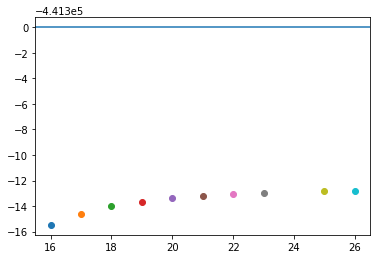

In [7]:
# plt.figure(figsize = (10,10))
# for dir, info in ecut_data.items():
#     key = 'total_energy'
#     print(info['conv_values'], dir)
#     plt.scatter(info['conv_values'], info[key], label = dir)

for dir, info in zbox_data.items():
    key = 'total_energy'
    plt.scatter(info['conv_values'], info[key], label = dir)

# for dir, info in econv_data.items():
#     key = 'total_energy'
#     plt.scatter(info['conv_values'], info[key], label = dir)

# for dir, info in forc_conv_data.items():
#     key = 'total_energy'
#     plt.scatter(info['conv_values'], info[key], label = dir)
    
# for dir, info in kpt_conv_data.items():
#     key = 'total_energy'
#     plt.scatter(info['conv_values'], info[key], label = dir)
    
plt.axhline(y = -441300)
# plt.legend()

40 ./1-ecut/1-ecut40
50 ./1-ecut/2-ecut50
60 ./1-ecut/3-ecut60
70 ./1-ecut/4-ecut70
75 ./1-ecut/4.5-ecut75
80 ./1-ecut/5-ecut80
90 ./1-ecut/6-ecut90
100 ./1-ecut/7-ecut100
110 ./1-ecut/8-ecut110
120 ./1-ecut/9-ecut120


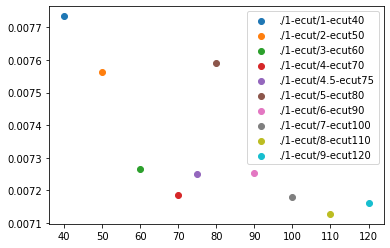

In [7]:
for dir, info in ecut_data.items():
    key = 'forces'
    print(info['conv_values'], dir)
    plt.scatter(info['conv_values'], np.linalg.norm(info[key],axis = -1).mean(), label = dir)

# for dir, info in zbox_data.items():
#     key = 'total_energy'
#     plt.scatter(info['conv_values'], info[key], label = dir)

# for dir, info in econv_data.items():
#     key = 'total_energy'
#     plt.scatter(info['conv_values'], info[key], label = dir)

# for dir, info in forc_conv_data.items():
#     key = 'forces'
#     plt.scatter(info['conv_values'], np.linalg.norm(info[key],axis = -1).mean(), label = dir)

plt.legend()

40 ./1-ecut/1-ecut40
50 ./1-ecut/2-ecut50
60 ./1-ecut/3-ecut60
70 ./1-ecut/4-ecut70
75 ./1-ecut/4.5-ecut75
80 ./1-ecut/5-ecut80
90 ./1-ecut/6-ecut90
100 ./1-ecut/7-ecut100
110 ./1-ecut/8-ecut110
120 ./1-ecut/9-ecut120


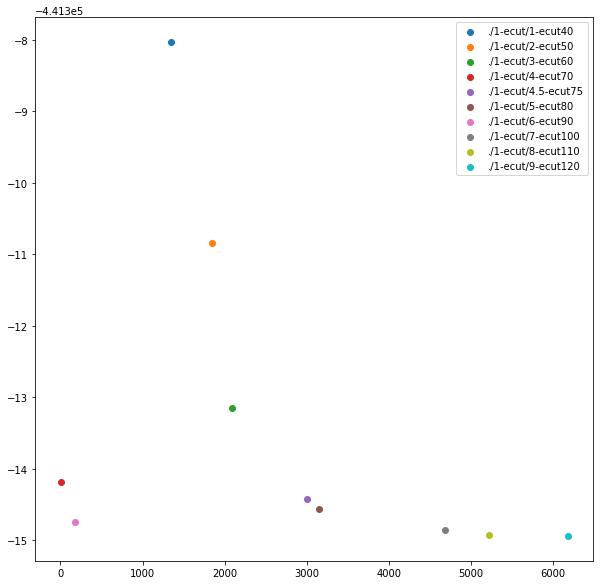

In [40]:
# plt.figure(figsize = (10,10))
# for dir, info in ecut_data.items():
#     key = 'total_energy'
#     print(info['conv_values'], dir)
#     plt.scatter(info['wall_time'], info[key], label = dir)

# # for dir, info in zbox_data.items():
# #     key = 'total_energy'
# #     print(info['conv_values'], dir)
# #     plt.scatter(info['wall_time'], info[key], label = dir)

# # for dir, info in econv_data.items():
# #     key = 'wall_time'
# #     plt.scatter(info['conv_values'], info[key], label = dir)

# # for dir, info in forc_conv_data.items():
# #     key = 'total_energy'
# #     plt.scatter(info['conv_values'], info[key], label = dir)
    
# # for dir, info in kpt_conv_data.items():
# #     key = 'total_energy'
# #     plt.scatter(info['conv_values'], info[key], label = dir)
    
# plt.legend()

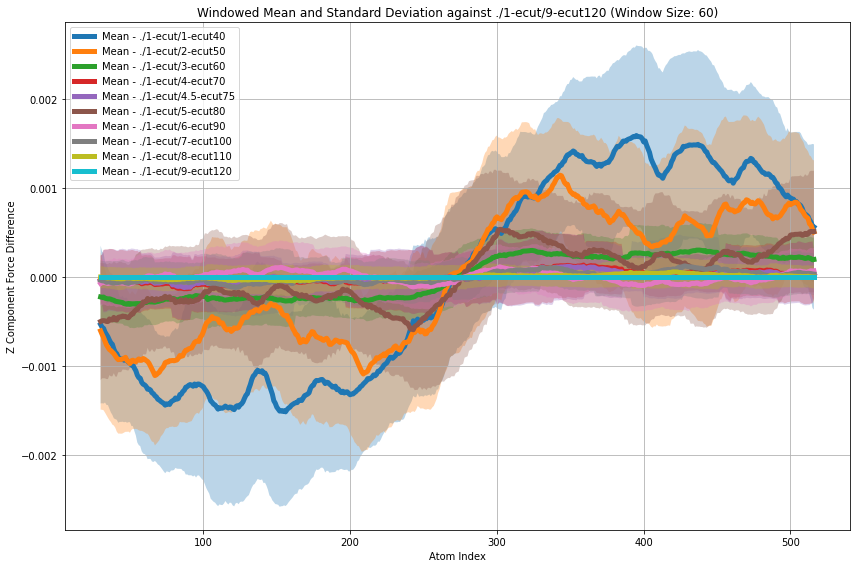

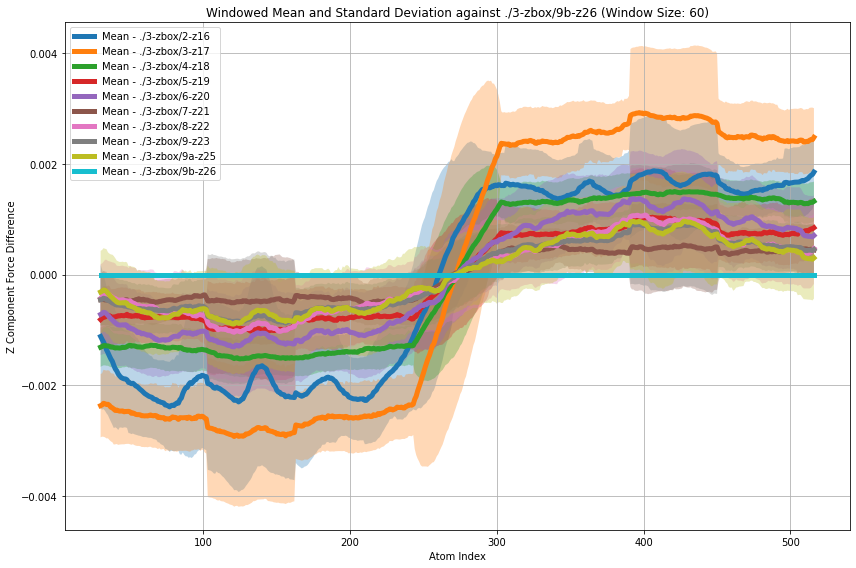

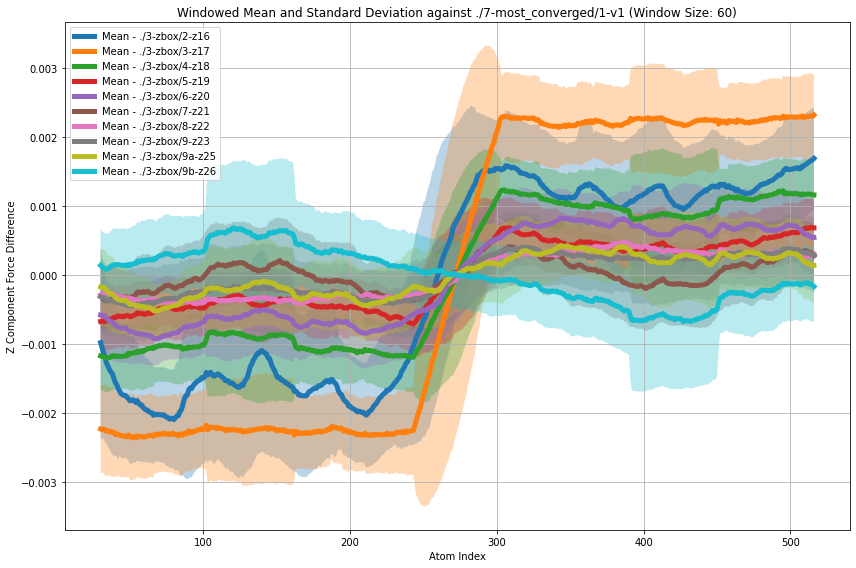

In [18]:
def plot_all_structures_against_reference(data, reference_structure, window_size=10):
    """
    Plots the windowed mean and standard deviation of the z component of force differences
    for all structures against a chosen reference structure.

    :param ecut_data: Dictionary containing force data for all structures
    :param reference_structure: Data of the reference structure in ecut_data
    :param window_size: Size of the window for calculating mean and std (default 10)
    """

    # Extracting reference structure forces
    ref_forces = reference_structure['forces']
    ref_directory = reference_structure['directory']

    # Plot setup
    plt.figure(figsize=(12, 8))
    plt.title(f'Windowed Mean and Standard Deviation against {ref_directory} (Window Size: {window_size})')
    plt.xlabel('Atom Index')
    plt.ylabel('Z Component Force Difference')

    # Loop through all structures and plot against reference
    for structure, data in data.items():
        

        # Calculating z component difference
        z_diff = data['forces'][:, 2] - ref_forces[:, 2]

        # Calculating windowed mean and std
        mean = np.convolve(z_diff, np.ones(window_size)/window_size, mode='valid')
        std = np.sqrt(np.convolve(z_diff**2, np.ones(window_size)/window_size, mode='valid') - mean**2)

        # Setting up indices for plotting
        indices = np.arange(len(mean)) + window_size // 2

        # Plotting
        plt.plot(indices, mean, label=f'Mean - {structure}', lw = 5)
        plt.fill_between(indices, mean - std, mean + std, alpha=0.3)

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_all_structures_against_reference(ecut_data, 'chosen_structure', window_size=10)
plot_all_structures_against_reference(ecut_data, ecut_data['./1-ecut/9-ecut120'], window_size=60)
plot_all_structures_against_reference(zbox_data, zbox_data['./3-zbox/9b-z26'], window_size=60)
plot_all_structures_against_reference(zbox_data, ref_conv_data['./7-most_converged/1-v1'], window_size=60)

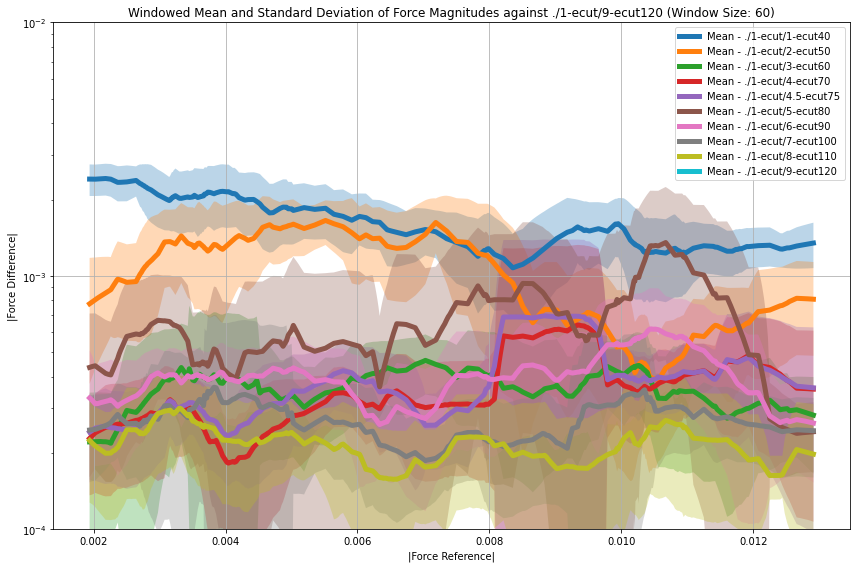

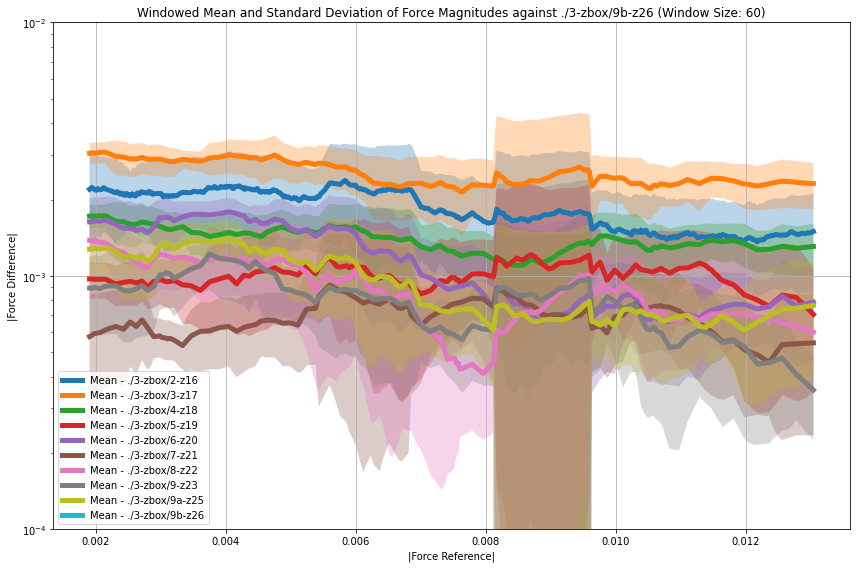

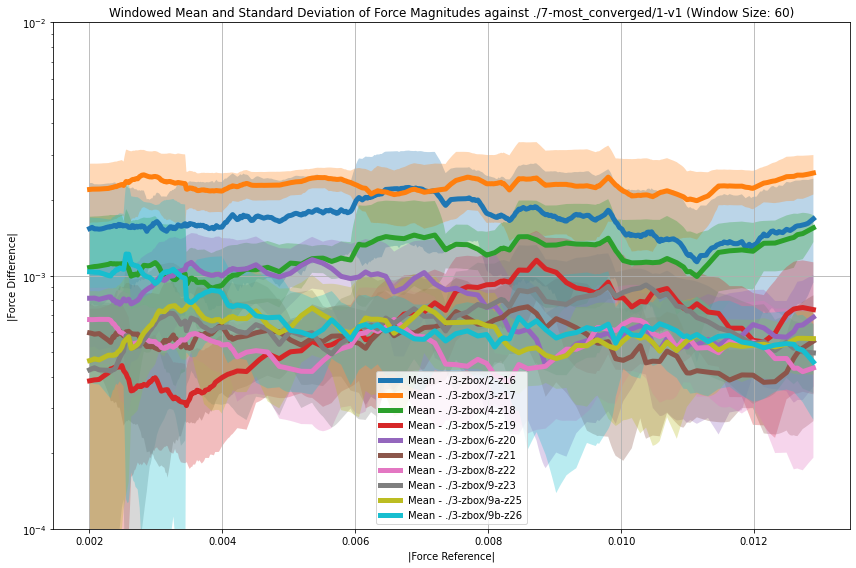

In [20]:
import matplotlib.pyplot as plt
import numpy as np


def plot_force_magnitude_mean_std(data, reference_structure, window_size=10):
    """
    Plots the windowed mean and standard deviation of the magnitude of force differences 
    against the magnitude of the reference force for each atom, sorted by the reference force magnitude.

    :param data: Dictionary containing force data for all structures
    :param reference_structure: Key of the reference structure in data
    :param window_size: Size of the window for calculating mean and std (default 10)
    """

   # Extracting reference structure forces
    ref_forces = reference_structure['forces']
    ref_directory = reference_structure['directory']

    plt.figure(figsize=(12, 8))
    plt.title(f'Windowed Mean and Standard Deviation of Force Magnitudes against {ref_directory} (Window Size: {window_size})')
    plt.xlabel('|Force Reference|')
    plt.ylabel('|Force Difference|')

    # Loop through all structures and plot against reference
    for structure, structure_data in data.items():
        # Calculating the magnitude of force differences and reference forces
        force_diff_magnitude = np.linalg.norm(structure_data['forces'] - ref_forces, axis=1)
        ref_force_magnitude = np.linalg.norm(ref_forces, axis=1)

        # Sorting the force magnitudes by reference force magnitude
        sorted_indices = np.argsort(ref_force_magnitude)
        sorted_diff_magnitude = force_diff_magnitude[sorted_indices]
        sorted_ref_force_magnitude = ref_force_magnitude[sorted_indices]

        # Calculating windowed mean and std for sorted force difference
        mean_diff = np.convolve(sorted_diff_magnitude, np.ones(window_size)/window_size, mode='valid')
        std_diff = np.sqrt(np.convolve(sorted_diff_magnitude**2, np.ones(window_size)/window_size, mode='valid') - mean_diff**2)

        # Calculating windowed mean for sorted reference force magnitude
        mean_ref_force = np.convolve(sorted_ref_force_magnitude, np.ones(window_size)/window_size, mode='valid')
        mean_ref_force = mean_ref_force[:len(mean_diff)]  # Adjusting size to match mean_diff

        # Plotting
        plt.plot(mean_ref_force, mean_diff, label=f'Mean - {structure}', lw=5)
        plt.fill_between(mean_ref_force, mean_diff - std_diff, mean_diff + std_diff, alpha=0.3)

    plt.legend()
    plt.grid(True)
    plt.ylim(1e-4,1e-2)
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_force_magnitude_mean_std(data, 'reference_structure', window_size=10)


plot_force_magnitude_mean_std(ecut_data, ecut_data['./1-ecut/9-ecut120'],window_size = 60)
plot_force_magnitude_mean_std(zbox_data, zbox_data['./3-zbox/9b-z26'], window_size = 60)
plot_force_magnitude_mean_std(zbox_data, ref_conv_data['./7-most_converged/1-v1'], window_size = 60)

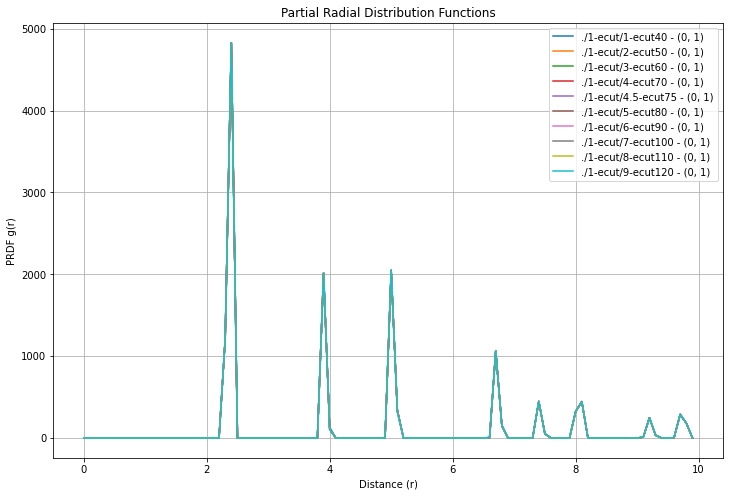

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def compute_prdf(positions, atom_types, pair_types, max_distance, bin_size, volume):
    """
    Compute the PRDF for specific pairs of atom types within a given structure.

    :param positions: Numpy array of atomic positions.
    :param atom_types: Numpy array of atomic types.
    :param pair_types: List of tuples for atom pairs to compute PRDF.
    :param max_distance: Maximum distance to consider for the PRDF.
    :param bin_size: Size of the bins for the histogram.
    :param volume: Total volume of the supercell.
    """
    prdf_data = {}
    for pair_type in pair_types:
        type_a, type_b = pair_type
        pos_a = positions[atom_types == type_a]
        pos_b = positions[atom_types == type_b]
        N_b = len(pos_b)

        # Initialize the PRDF array
        prdf = np.zeros(int(max_distance/bin_size))
        bin_edges = np.linspace(0, max_distance, len(prdf) + 1)

        for a in pos_a:
            # Compute distances from atom a to all atoms of type b
            distances = cdist([a], pos_b, 'euclidean').flatten()
            # Count number of atoms in each bin
            bin_counts = np.histogram(distances, bins=bin_edges)[0]
            prdf += bin_counts

        # Normalize by the shell volume and total number of b atoms, and scale by the total volume
        shell_volume = 4 * np.pi * (bin_edges[1:]**2) * bin_size
        
        prdf = prdf * volume / (N_b * shell_volume)

        # Store the computed PRDF
        prdf_data[pair_type] = (bin_edges[:-1], prdf)

    return prdf_data

def plot_prdf(data, pair_types, max_distance, bin_size):
    """
    Plot PRDFs for different structures with atom type information.

    :param data: Dictionary containing structures' data with atom types.
    :param pair_types: List of tuples for atom pairs to compute PRDF.
    :param max_distance: Maximum distance to consider for the PRDF.
    :param bin_size: Size of the bins for the histogram.
    :param volume: Total volume of the supercell.
    """
    plt.figure(figsize=(12, 8))

    for structure_name, structure_data in data.items():
        positions = structure_data['positions']
        atom_types = structure_data['atom_types']
        volume = structure_data['volume']
        prdf_data = compute_prdf(positions, atom_types, pair_types, max_distance, bin_size, volume)
        for pair_type, (distances, prdf_values) in prdf_data.items():
            plt.plot(distances, prdf_values, label=f'{structure_name} - {pair_type}')

    plt.xlabel('Distance (r)')
    plt.ylabel('PRDF g(r)')
    plt.title('Partial Radial Distribution Functions')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# data = extract_qe_data(directories, vals)
# volume = ...  # You should calculate or define the volume of your supercell here
plot_prdf(ecut_data, [(0, 1)], max_distance=10, bin_size=0.1)


./3-zbox/1-z15 468.97
./3-zbox/2-z16 1732.1
./3-zbox/3-z17 1701.94
./3-zbox/4-z18 1820.3
./3-zbox/5-z19 2054.27
./3-zbox/6-z20 2122.08
./3-zbox/7-z21 1993.38
./3-zbox/8-z22 2115.36
./3-zbox/9-z23 9.58
./3-zbox/9a-z25 6360
./3-zbox/9b-z26 5820


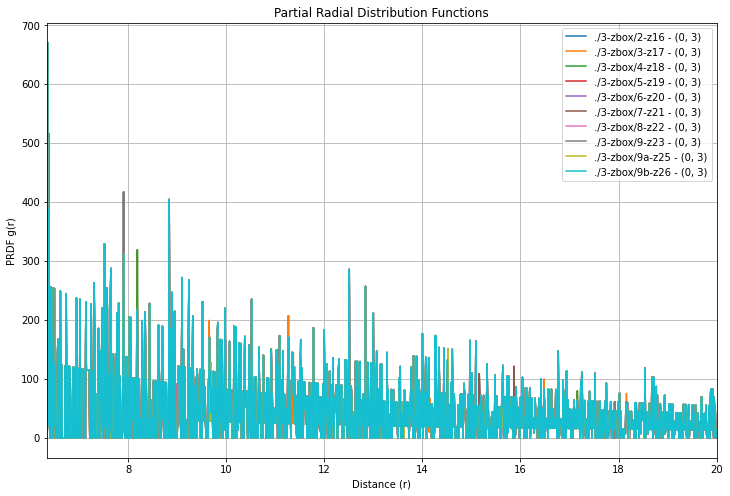

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def compute_2d_prdf(positions, atom_types, pair_types, max_distance, bin_size, area):
    """
    Compute the 2D PRDF for specific pairs of atom types within a given structure.

    :param positions: Numpy array of atomic positions.
    :param atom_types: Numpy array of atomic types.
    :param pair_types: List of tuples for atom pairs to compute PRDF.
    :param max_distance: Maximum distance to consider for the PRDF.
    :param bin_size: Size of the bins for the histogram.
    :param area: Total area of the 2D layer.
    """
    prdf_data = {}
    for pair_type in pair_types:
        type_a, type_b = pair_type
        pos_a = positions[atom_types == type_a]
        pos_b = positions[atom_types == type_b]
        N_b = len(pos_b)

        # Initialize the PRDF array
        prdf = np.zeros(int(max_distance/bin_size))
        bin_edges = np.linspace(0, max_distance, len(prdf) + 1)

        for a in pos_a:
            # Compute distances from atom a to all atoms of type b
            distances = cdist([a], pos_b, 'euclidean').flatten()
            # Count number of atoms in each bin
            bin_counts = np.histogram(distances, bins=bin_edges)[0]
            prdf += bin_counts
        # print(np.linalg.norm(pos_b))

        # Normalize by the ring area and total number of b atoms, and scale by the total area
        # ring_area = 2 * np.pi * bin_edges[1:] * bin_size
        ring_area = np.pi * (bin_edges[1:]**2 - bin_edges[:-1]**2)

        # print(area,ring_area.mean(), N_b)
        prdf = prdf * area / (N_b * ring_area)

        # Store the computed PRDF
        prdf_data[pair_type] = (bin_edges[:-1], prdf)

    return prdf_data

def plot_prdf(data, pair_types, max_distance, bin_size, range):
    """
    Plot PRDFs for different structures with atom type information.

    :param data: Dictionary containing structures' data with atom types.
    :param pair_types: List of tuples for atom pairs to compute PRDF.
    :param max_distance: Maximum distance to consider for the PRDF.
    :param bin_size: Size of the bins for the histogram.
    :param range: xlim range.
    """
    plt.figure(figsize=(12, 8))
    atom_type_array = []
    for structure_name, structure_data in data.items():
        positions = structure_data['positions']
        
        atom_types = structure_data['atom_types']
        # print(positions[:,2])
        # print(atom_types)
        area = structure_data['area']
        prdf_data = compute_2d_prdf(positions, atom_types, pair_types, max_distance, bin_size, area)
        for pair_type, (distances, prdf_values) in prdf_data.items():
            plt.plot(distances, prdf_values, label=f'{structure_name} - {pair_type}')

    plt.xlabel('Distance (r)')
    plt.ylabel('PRDF g(r)')
    plt.title('Partial Radial Distribution Functions')
    plt.legend()
    plt.grid(True)
    plt.xlim(range[0],range[1])
    plt.show()

    
zbox_dirs = get_subdirectories('./3-zbox/')


zbox_vals = [15,16,17,18,19, 20, 21, 22, 23, 25,26]


zbox_data = extract_qe_data(zbox_dirs, zbox_vals)
zbox_data.pop('./3-zbox/1-z15')

plot_prdf(zbox_data, [(0, 3)], max_distance=20, bin_size=0.01, range = (6.35,20))



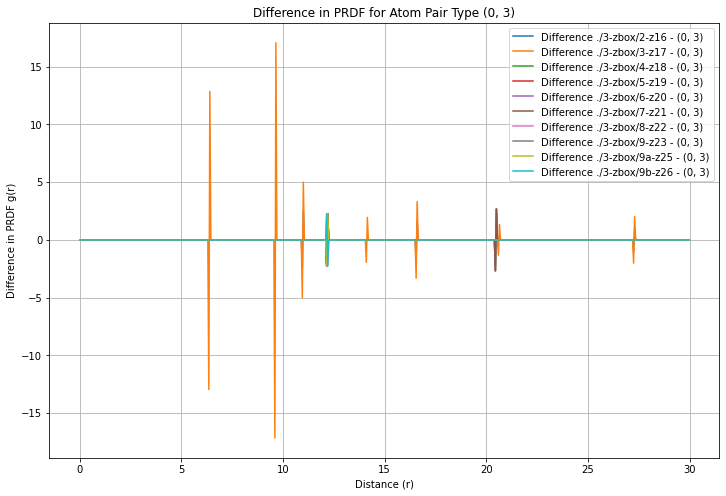

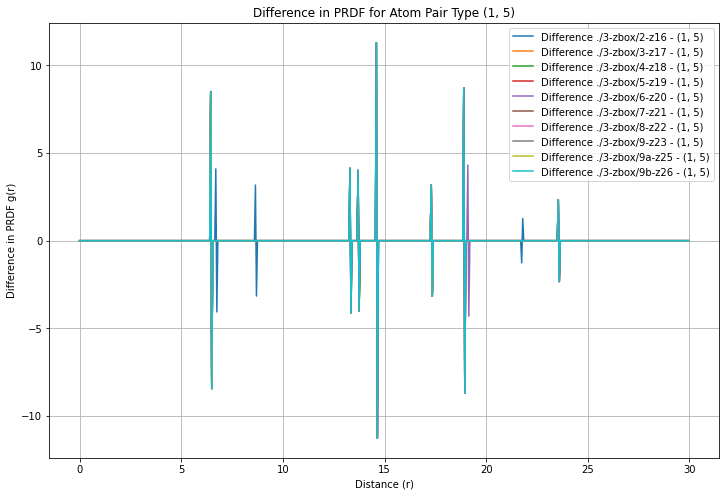

In [23]:
def compute_difference_prdf(ref_prdf_data, comp_prdf_data, pair_type):
    """
    Compute the difference in 2D PRDF between a reference structure and a comparison structure for a given pair type.

    :param ref_prdf_data: PRDF data for the reference structure.
    :param comp_prdf_data: PRDF data for the comparison structure.
    :param pair_type: Tuple for atom pair to compute PRDF.
    :return: Tuple containing the distances and the difference in PRDF for the given pair type.
    """
    # Extract the PRDF data for the reference and comparison structures for the given pair type
    ref_distances, ref_prdf_values = ref_prdf_data[pair_type]
    comp_distances, comp_prdf_values = comp_prdf_data[pair_type]
    
    # Check that the distance bins are identical for the reference and comparison
    if not np.array_equal(ref_distances, comp_distances):
        raise ValueError("The distance bins for the reference and comparison PRDFs do not match.")
    
    # Calculate the difference in PRDF values
    prdf_difference = comp_prdf_values - ref_prdf_values
    
    return ref_distances, prdf_difference

def plot_difference_prdf(ref_data, comp_data, pair_types, max_distance, bin_size):
    """
    Plot the difference in PRDFs for a comparison structure against a reference structure for each pair type.

    :param ref_data: PRDF data for the reference structure.
    :param comp_data: Dictionary containing PRDF data for comparison structures.
    :param pair_types: List of tuples for atom pairs to compute PRDF.
    :param max_distance: Maximum distance to consider for the PRDF.
    :param bin_size: Size of the bins for the histogram.
    """
    # Compute PRDF for the reference structure
    ref_positions = ref_data['positions']
    ref_atom_types = ref_data['atom_types']
    ref_area = ref_data['area']
    ref_prdf_data = compute_2d_prdf(ref_positions, ref_atom_types, pair_types, max_distance, bin_size, ref_area)
    
    # Compute PRDF for each comparison structure
    for pair_type in pair_types:
        plt.figure(figsize=(12, 8))
        
        for structure_name, structure_data in comp_data.items():
            comp_positions = structure_data['positions']
            comp_atom_types = structure_data['atom_types']
            comp_area = structure_data['area']
            comp_prdf_data = compute_2d_prdf(comp_positions, comp_atom_types, [pair_type], max_distance, bin_size, comp_area)
            
            # Compute the difference in PRDF
            distances, prdf_difference = compute_difference_prdf(ref_prdf_data, comp_prdf_data, pair_type)
            
            # Plot the difference in PRDF for the given atom pair type
            plt.plot(distances, prdf_difference, label=f'Difference {structure_name} - {pair_type}')
        
        plt.xlabel('Distance (r)')
        plt.ylabel('Difference in PRDF g(r)')
        plt.title(f'Difference in PRDF for Atom Pair Type {pair_type}')
        plt.legend()
        plt.grid(True)
        plt.show()
        
plot_difference_prdf(ref_conv_data['./7-most_converged/1-v1'], zbox_data, pair_types = [(0,3),(1,5)], max_distance = 30, bin_size = 0.05)

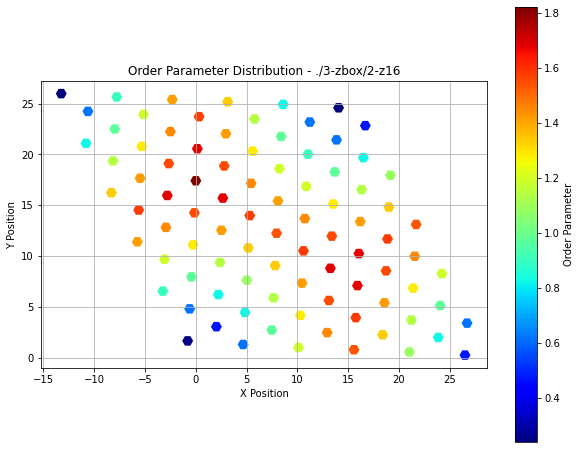

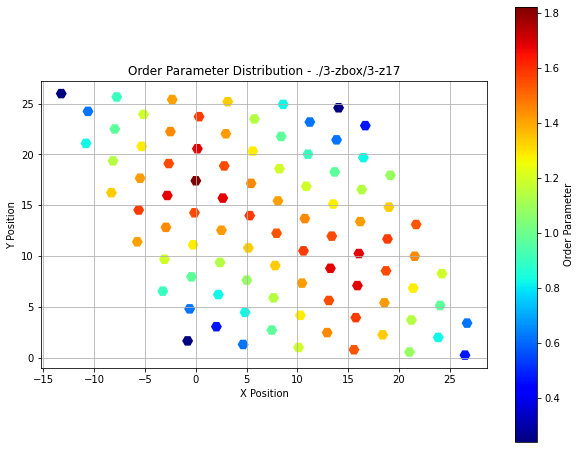

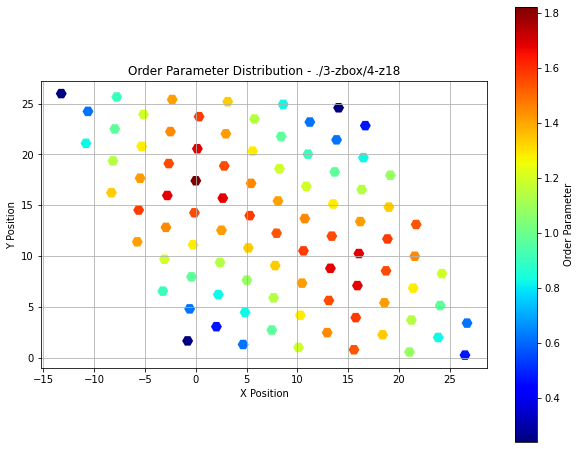

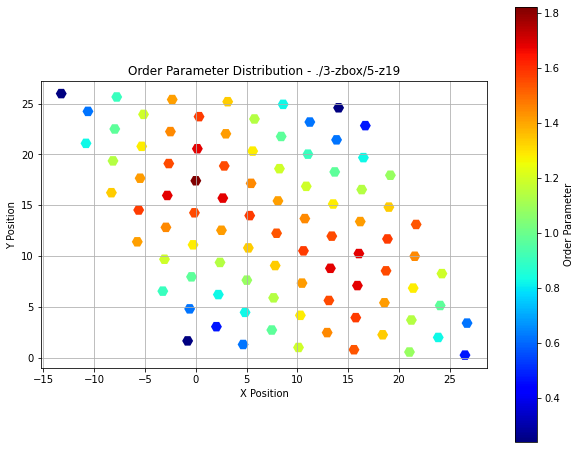

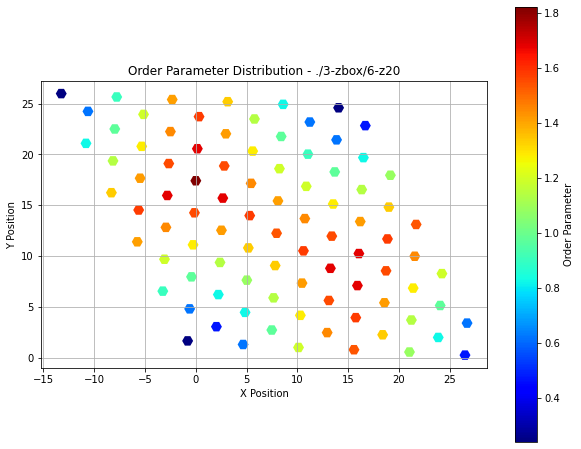

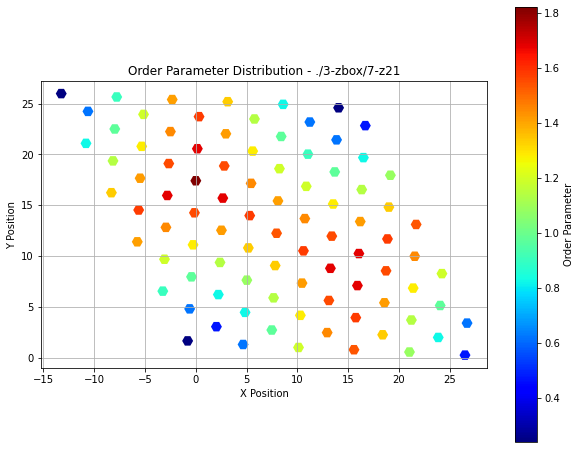

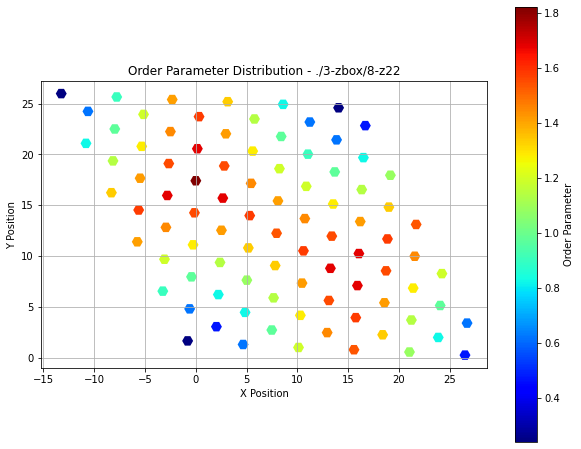

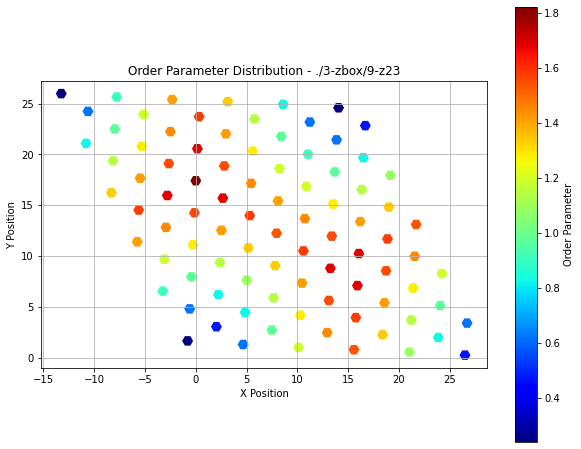

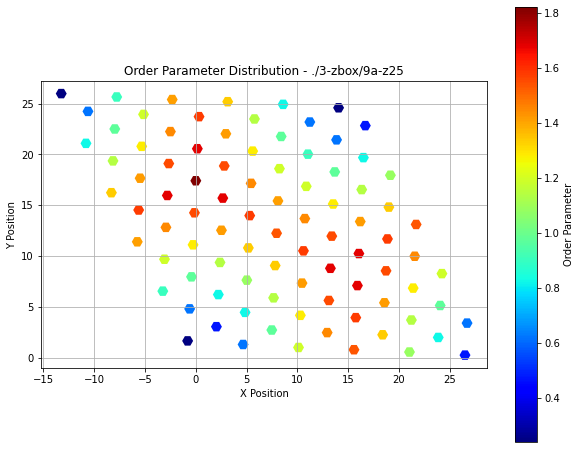

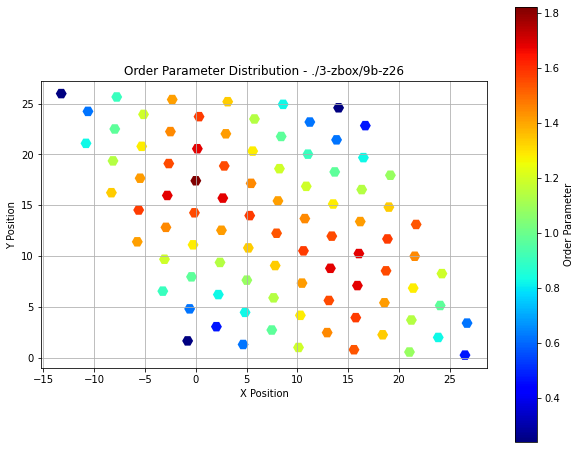

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

def calculate_order_parameter(positions, atom_types, type_lower, type_upper, cell):
    """
    Calculate the order parameter for atoms in a layered structure.

    :param positions: Numpy array of atomic positions.
    :param atom_types: Numpy array of atomic types.
    :param type_lower: Type number for the lower layer.
    :param type_upper: Type number for the upper layer.
    :param cell: Cell vectors of the structure.
    :return: Array of positions and corresponding order parameter values.
    """
    pos_lower = positions[atom_types == type_lower]
    pos_upper = positions[atom_types == type_upper]

    # Create a supercell for the upper layer
    A1 = cell[0,:2]
    A2 = cell[1,:2]
    pos_upper_sc = rep_cell(pos_upper, A1, A2)

    # Using cKDTree to find nearest neighbors in the upper layer for each atom in the lower layer
    tree = cKDTree(pos_upper_sc[:,:2])
    dist, _ = tree.query(pos_lower[:,:2])

    order_param = np.zeros((len(pos_lower), 3))
    order_param[:, :2] = pos_lower[:, :2]
    order_param[:, 2] = dist

    return order_param

def rep_cell(pos, a_1, a_2):
    """
    Replicate the unit cell in the xy plane.
    """
    pos_sc = []
    for i in range(-1, 2):
        for j in range(-1, 2):
            for p in pos:
                pos_sc.append(p + i*np.array([a_1[0],a_1[1],0.0]) + j*np.array([a_2[0],a_2[1],0.0]))
    return np.array(pos_sc)

def plot_order_parameter(data, type_lower, type_upper):
    """
    Plot the order parameter for each structure in the data.

    :param data: Dictionary containing structure data.
    :param type_lower: Type number for the lower layer.
    :param type_upper: Type number for the upper layer.
    """
    for directory, structure_data in data.items():
        positions = structure_data['positions']
        atom_types = structure_data['atom_types']
        cell = structure_data['cell']

        order_param = calculate_order_parameter(positions, atom_types, type_lower, type_upper, cell)

        plt.figure(figsize=(10, 8))
        plt.scatter(order_param[:,0], order_param[:,1], s=120, c=order_param[:,2], cmap='jet', marker='H', edgecolor="None")
        plt.colorbar(label='Order Parameter')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.title(f'Order Parameter Distribution - {directory}')
        plt.grid(True)
        plt.axis('scaled')
        plt.show()

# Example usage:
# Assuming 'data' is the dictionary returned from extract_qe_data
# type_lower = 0 # Replace with the type number for the lower layer
# type_upper = 1 # Replace with the type number for the upper layer
# plot_order_parameter(data, type_lower, type_upper)
plot_order_parameter(zbox_data, type_lower = 0, type_upper = 3)

./3-zbox/2-z16 0.010514148564530474
./3-zbox/3-z17 0.00893967851442236
./3-zbox/4-z18 0.004777390027968762
./3-zbox/5-z19 0.004308878624126932
./3-zbox/6-z20 0.00459412253097629
./3-zbox/7-z21 0.003107544357712
./3-zbox/8-z22 0.003349532703547226
./3-zbox/9-z23 0.0029245016863410846
./3-zbox/9a-z25 0.00410185366427907
./3-zbox/9b-z26 0.0


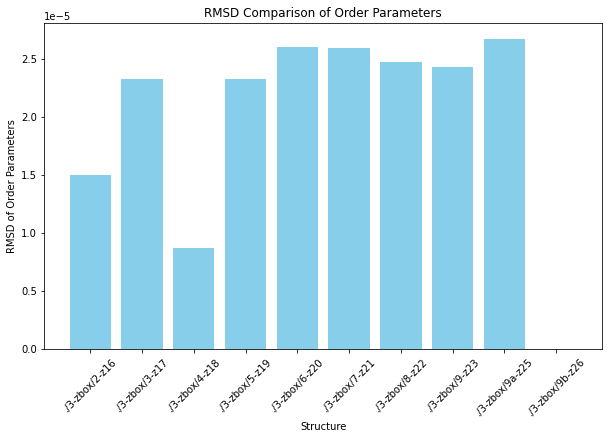

./1-ecut/1-ecut40 0.021315407691559513
./1-ecut/2-ecut50 0.010436945331513276
./1-ecut/3-ecut60 0.004972442172831163
./1-ecut/4-ecut70 0.0028410388392783007
./1-ecut/4.5-ecut75 0.002481330195082453
./1-ecut/5-ecut80 0.0015724040638590703
./1-ecut/6-ecut90 0.0012994033296856006
./1-ecut/7-ecut100 0.0011108152522282038
./1-ecut/8-ecut110 0.0005768224378537584
./1-ecut/9-ecut120 0.0


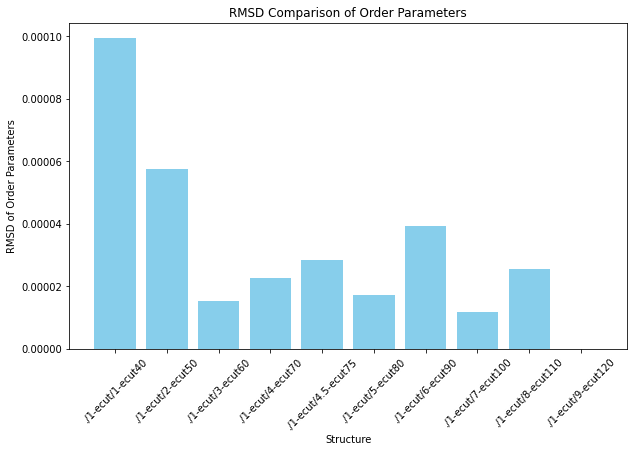

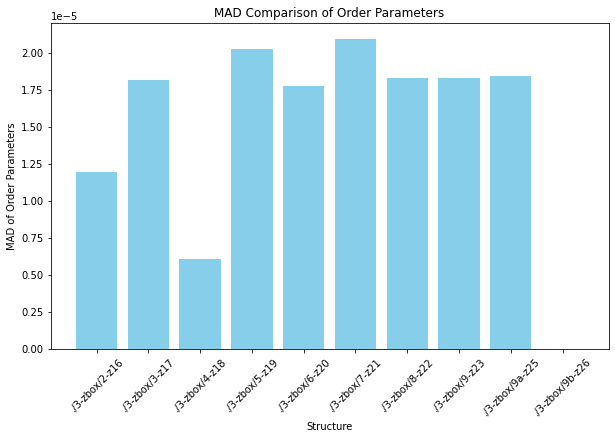

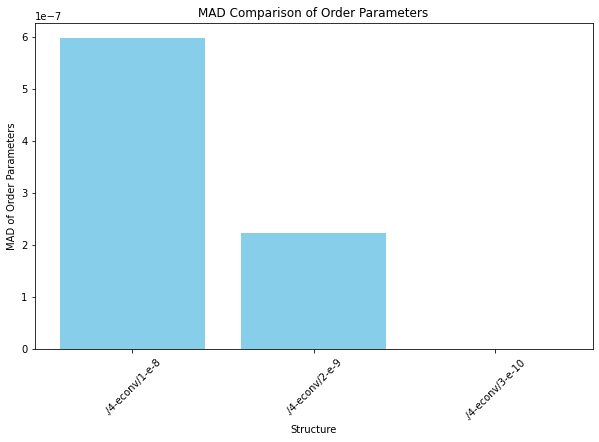

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

def calculate_order_parameter(positions, atom_types, type_lower, type_upper, cell):
    pos_lower = positions[atom_types == type_lower]
    pos_upper = positions[atom_types == type_upper]

    A1, A2 = cell[0, :2], cell[1, :2]
    pos_upper_sc = rep_cell(pos_upper, A1, A2)

    tree = cKDTree(pos_upper_sc[:, :2])
    dist, _ = tree.query(pos_lower[:, :2])

    order_param = np.zeros((len(pos_lower), 3))
    order_param[:, :2] = pos_lower[:, :2]
    order_param[:, 2] = dist
    return order_param

def rep_cell(pos, a_1, a_2):
    pos_sc = []
    for i in range(-1, 2):
        for j in range(-1, 2):
            for p in pos:
                pos_sc.append(p + i * np.array([a_1[0], a_1[1], 0.0]) + j * np.array([a_2[0], a_2[1], 0.0]))
    return np.array(pos_sc)

def calculate_rmsd(op1, op2):
    if len(op1) != len(op2):
        raise ValueError("Order parameter arrays must be of the same length.")
    squared_diffs = np.square(op1[:, 2] - op2[:, 2])
    mean_squared_diff = np.mean(squared_diffs)
    return np.sqrt(mean_squared_diff)

def calculate_mean_absolute_difference(op1, op2):
    """
    Calculate the Mean Absolute Difference (MAD) between two sets of order parameters.

    :param op1: Order parameters for the first structure.
    :param op2: Order parameters for the second structure.
    :return: MAD value.
    """
    if len(op1) != len(op2):
        raise ValueError("Order parameter arrays must be of the same length.")

    # Calculate the absolute differences and take the mean
    absolute_diffs = np.abs(op1[:, 2] - op2[:, 2])
    mean_absolute_diff = np.mean(absolute_diffs)

    return mean_absolute_diff


def calculate_and_plot_rmsd(base_structure, comparison_structures, type_lower, type_upper):
    base_order_param = calculate_order_parameter(base_structure['positions'], base_structure['atom_types'], 
                                                 type_lower, type_upper, base_structure['cell'])

    rmsd_values = []
    structure_names = []

    for name, structure in comparison_structures.items():
        print(name, np.linalg.norm(base_structure['positions']- structure['positions']))
        comp_order_param = calculate_order_parameter(structure['positions'], structure['atom_types'], 
                                                     type_lower, type_upper, structure['cell'])
        rmsd = calculate_rmsd(base_order_param, comp_order_param)
        rmsd_values.append(rmsd)
        structure_names.append(name)

    plt.figure(figsize=(10, 6))
    plt.bar(structure_names, rmsd_values, color='skyblue')
    plt.xlabel('Structure')
    plt.ylabel('RMSD of Order Parameters')
    plt.title('RMSD Comparison of Order Parameters')
    plt.xticks(rotation=45)
    plt.show()

def calculate_and_plot_mad(base_structure, comparison_structures, type_lower, type_upper):
    base_order_param = calculate_order_parameter(base_structure['positions'], base_structure['atom_types'], 
                                                 type_lower, type_upper, base_structure['cell'])

    mad_values = []
    structure_names = []

    for name, structure in comparison_structures.items():
        comp_order_param = calculate_order_parameter(structure['positions'], structure['atom_types'], 
                                                     type_lower, type_upper, structure['cell'])
        mad = calculate_mean_absolute_difference(base_order_param, comp_order_param)
        mad_values.append(mad)
        structure_names.append(name)

    plt.figure(figsize=(10, 6))
    plt.bar(structure_names, mad_values, color='skyblue')
    plt.xlabel('Structure')
    plt.ylabel('MAD of Order Parameters')
    plt.title('MAD Comparison of Order Parameters')
    plt.xticks(rotation=45)
    plt.show()

# Example usage:
# base_structure = data['base_structure_key']  # Replace with your base structure key
# comparison_structures = {k: v for k, v in data.items() if k != 'base_structure_key'}  # Filter out base structure
# type_lower = 0  # Replace with atom type for lower layer
# type_upper = 1  # Replace with atom type for upper layer
calculate_and_plot_rmsd(zbox_data['./3-zbox/9b-z26'], zbox_data, type_lower = 0, type_upper = 3)
calculate_and_plot_rmsd(ecut_data['./1-ecut/9-ecut120'], ecut_data, type_lower = 0, type_upper = 3)

calculate_and_plot_mad(zbox_data['./3-zbox/9b-z26'], zbox_data, type_lower = 0, type_upper = 3)
calculate_and_plot_mad(econv_data['./4-econv/3-e-10'], econv_data, type_lower = 0, type_upper = 3)





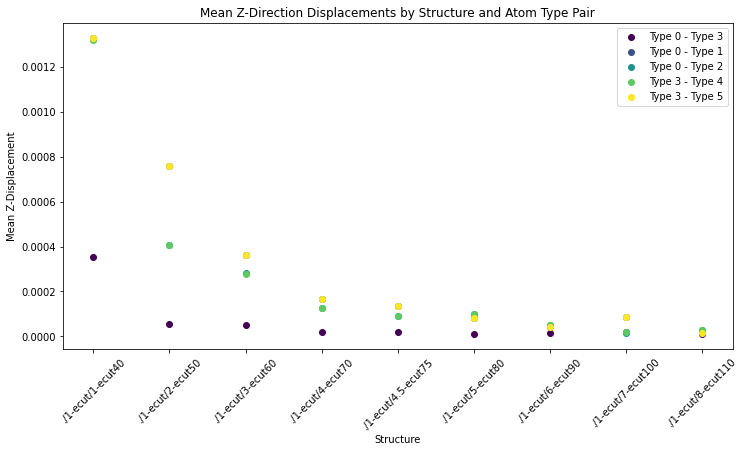

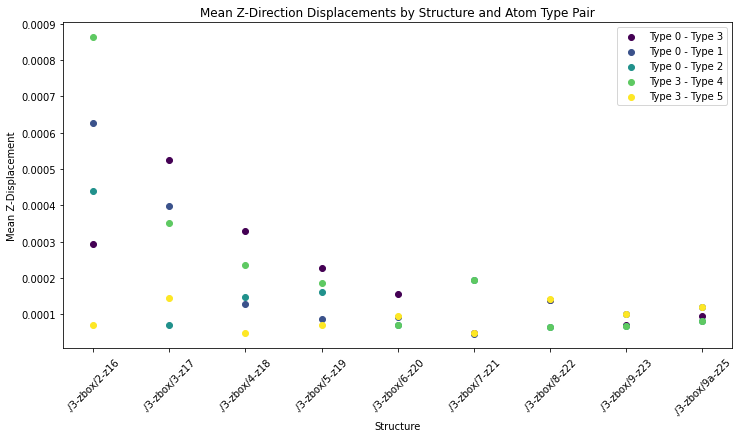

In [29]:
import numpy as np

def calculate_z_displacements(positions, atom_types, type_a, type_b):
    """
    Calculate z-direction displacements between pairs of specified atom types.

    :param positions: Numpy array of atomic positions.
    :param atom_types: Numpy array of atomic types.
    :param type_a: The first atom type for displacement calculation.
    :param type_b: The second atom type for displacement calculation.
    :return: Array of z-direction displacements between each pair of specified atom types.
    """
    pos_a_z = positions[atom_types == type_a][:, 2]  # Z coordinates of type_a atoms
    pos_b_z = positions[atom_types == type_b][:, 2]  # Z coordinates of type_b atoms

    # Find the minimum z-direction displacement between each atom in pos_a and pos_b
    z_displacements = np.min(np.abs(pos_a_z[:, np.newaxis] - pos_b_z), axis=1)
    return z_displacements

def calculate_mean_z_displacement(data, ref_structure_key, type_a, type_b):
    """
    Calculate the mean displacement of z-direction distances between specific atom types,
    comparing a reference structure with all other structures in the dataset.

    :param data: Dictionary containing structure data.
    :param ref_structure_key: Key for the reference structure in the data dictionary.
    :param type_a: The first atom type for displacement comparison.
    :param type_b: The second atom type for displacement comparison.
    :return: Dictionary of mean displacements for each structure compared to the reference.
    """
    mean_displacements = {}

    # Calculate z-direction displacements in the reference structure
    ref_z_displacements = calculate_z_displacements(data[ref_structure_key]['positions'],
                                                    data[ref_structure_key]['atom_types'], 
                                                    type_a, type_b)

    # Compare with each other structure
    for key, structure in data.items():
        if key != ref_structure_key:
            comp_z_displacements = calculate_z_displacements(structure['positions'],
                                                             structure['atom_types'], 
                                                             type_a, type_b)

            # Calculate mean displacement
            mean_displacement = np.mean(np.abs(ref_z_displacements - comp_z_displacements))
            mean_displacements[key] = mean_displacement

    return mean_displacements

# Example usage:
# data = extract_qe_data(directories, vals)
# ref_structure_key = 'ref_structure'  # Replace with the key of your reference structure
# type_a, type_b = 0, 3  # Replace with actual atom types for comparison
# mean_displacements = calculate_mean_z_displacement(data, ref_structure_key, type_a, type_b)
# print(mean_displacements)


import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_mean_z_displacements(data, ref_structure_key, atom_type_pairs):
    """
    Plot the mean z-direction displacements for each structure and each pair of atom types.

    :param data: Dictionary containing structure data.
    :param ref_structure_key: Key for the reference structure in the data dictionary.
    :param atom_type_pairs: List of tuples of atom type pairs to compare.
    """
    structure_names = [key for key in data.keys() if key != ref_structure_key]
    num_pairs = len(atom_type_pairs)

    # Prepare a scatter plot for mean displacements
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, num_pairs))

    for idx, (type_a, type_b) in enumerate(atom_type_pairs):
        mean_displacements = calculate_mean_z_displacement(data, ref_structure_key, type_a, type_b)
        ax.scatter(structure_names, [mean_displacements[name] for name in structure_names], 
                   label=f'Type {type_a} - Type {type_b}', color=colors[idx])

    ax.set_xlabel('Structure')
    ax.set_ylabel('Mean Z-Displacement')
    ax.set_title('Mean Z-Direction Displacements by Structure and Atom Type Pair')
    ax.legend()
    plt.xticks(rotation=45)
    plt.show()

def plot_absolute_z_distances(data, atom_type_pairs):
    """
    Plot the absolute z-direction distances for each structure and each pair of atom types.

    :param data: Dictionary containing structure data.
    :param atom_type_pairs: List of tuples of atom type pairs to compare.
    """
    structure_names = list(data.keys())
    num_pairs = len(atom_type_pairs)

    # Prepare a scatter plot for absolute z-direction distances
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, num_pairs))

    for idx, (type_a, type_b) in enumerate(atom_type_pairs):
        z_distances = {name: np.mean(calculate_z_displacements(structure['positions'], 
                                                              structure['atom_types'], 
                                                              type_a, type_b))
                       for name, structure in data.items()}
        ax.scatter(structure_names, [z_distances[name] for name in structure_names], 
                   label=f'Type {type_a} - Type {type_b}', color=colors[idx])

    ax.set_xlabel('Structure')
    ax.set_ylabel('Absolute Z-Distance')
    ax.set_title('Absolute Z-Direction Distances by Structure and Atom Type Pair')
    ax.legend()
    ax.axhline(y = 0)
    plt.xticks(rotation=45)
    plt.show()

# Example usage:
# atom_type_pairs = [(0, 3), (1, 4), (2, 5)]  # Replace with actual atom type pairs
# plot_mean_z_displacements(data, ref_structure_key, atom_type_pairs)
# plot_absolute_z_distances(data, atom_type_pairs)
    
plot_mean_z_displacements(ecut_data, './1-ecut/9-ecut120', atom_type_pairs = [(0,3),(0,1),(0,2),(3,4),(3,5)])
plot_mean_z_displacements(zbox_data, './3-zbox/9b-z26', atom_type_pairs = [(0,3),(0,1),(0,2),(3,4),(3,5)])

# plot_absolute_z_distances(ecut_data, atom_type_pairs = [(0,3),(0,1)])

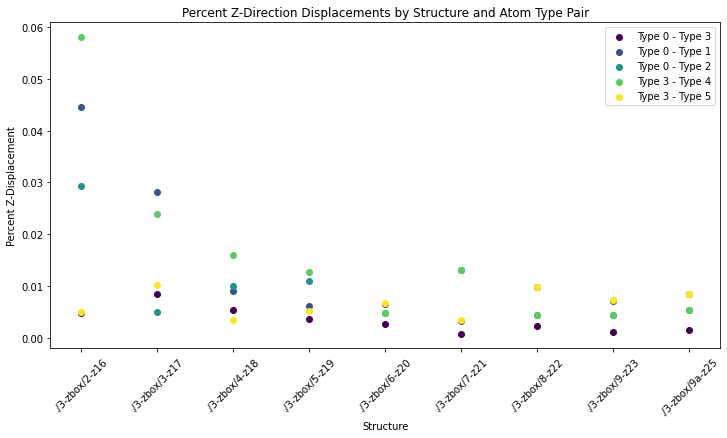

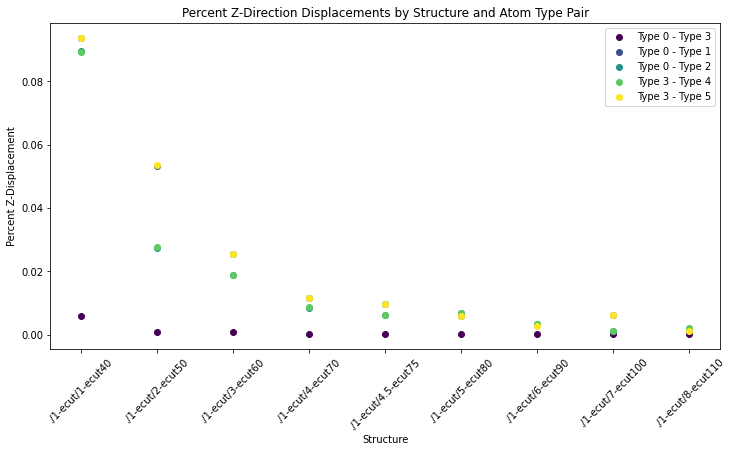

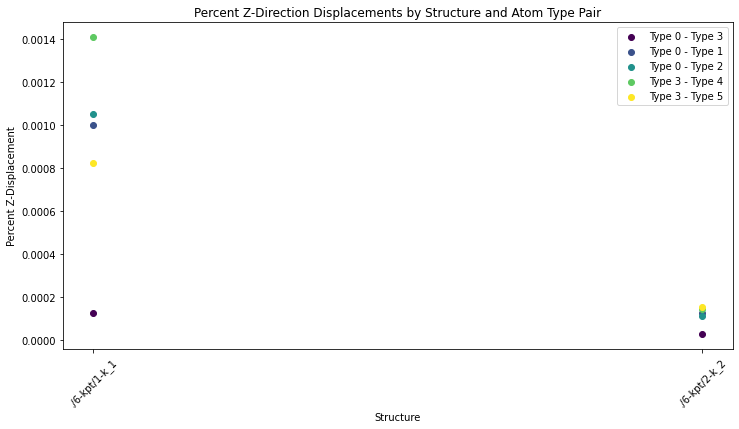

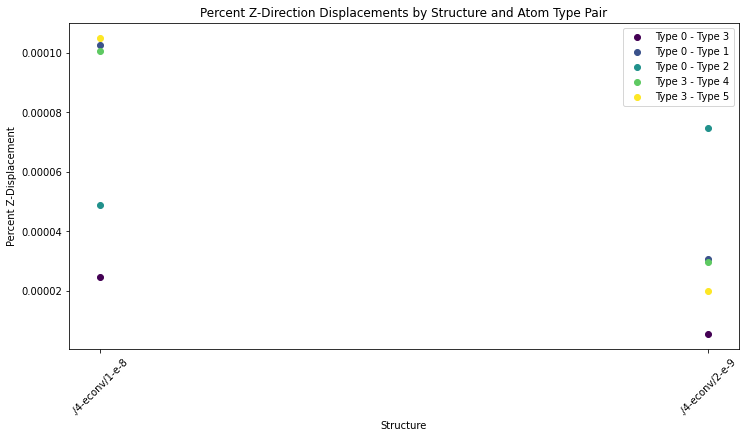

In [38]:
def calculate_percent_z_displacement(data, ref_structure_key, type_a, type_b):
    """
    Calculate the percent displacement of z-direction distances between specific atom types,
    comparing a reference structure with all other structures in the dataset.

    :param data: Dictionary containing structure data.
    :param ref_structure_key: Key for the reference structure in the data dictionary.
    :param type_a: The first atom type for displacement comparison.
    :param type_b: The second atom type for displacement comparison.
    :return: Dictionary of percent displacements for each structure compared to the reference.
    """
    percent_displacements = {}

    # Calculate z-direction displacements in the reference structure
    ref_z_displacements = calculate_z_displacements(data[ref_structure_key]['positions'],
                                                    data[ref_structure_key]['atom_types'], 
                                                    type_a, type_b)

    # Compare with each other structure
    for key, structure in data.items():
        if key != ref_structure_key:
            comp_z_displacements = calculate_z_displacements(structure['positions'],
                                                             structure['atom_types'], 
                                                             type_a, type_b)

            # Calculate percent displacement
            # Avoid division by zero: add a small constant (e.g., 1e-9) to ref_z_displacements
            percent_displacement = np.mean(np.abs(ref_z_displacements - comp_z_displacements) / (ref_z_displacements + 1e-9)) * 100
            percent_displacements[key] = percent_displacement

    return percent_displacements

def plot_percent_z_displacements(data, ref_structure_key, atom_type_pairs):
    """
    Plot the percent z-direction displacements for each structure and each pair of atom types.

    :param data: Dictionary containing structure data.
    :param ref_structure_key: Key for the reference structure in the data dictionary.
    :param atom_type_pairs: List of tuples of atom type pairs to compare.
    """
    structure_names = [key for key in data.keys() if key != ref_structure_key]
    num_pairs = len(atom_type_pairs)

    # Prepare a scatter plot for percent displacements
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, num_pairs))

    for idx, (type_a, type_b) in enumerate(atom_type_pairs):
        percent_displacements = calculate_percent_z_displacement(data, ref_structure_key, type_a, type_b)
        ax.scatter(structure_names, [percent_displacements[name] for name in structure_names], 
                   label=f'Type {type_a} - Type {type_b}', color=colors[idx])

    ax.set_xlabel('Structure')
    ax.set_ylabel('Percent Z-Displacement')
    ax.set_title('Percent Z-Direction Displacements by Structure and Atom Type Pair')
    ax.legend()
    plt.xticks(rotation=45)
    plt.show()

plot_percent_z_displacements(zbox_data, './3-zbox/9b-z26', atom_type_pairs = [(0,3),(0,1),(0,2),(3,4),(3,5)])
plot_percent_z_displacements(ecut_data, './1-ecut/9-ecut120', atom_type_pairs = [(0,3),(0,1),(0,2),(3,4),(3,5)])
plot_percent_z_displacements(kpt_conv_data, './6-kpt/3-k_3', atom_type_pairs = [(0,3),(0,1),(0,2),(3,4),(3,5)])
plot_percent_z_displacements(econv_data, './4-econv/3-e-10', atom_type_pairs = [(0,3),(0,1),(0,2),(3,4),(3,5)])




In [33]:
zbox_data['./3-zbox/6-z20']['positions'][:,2] - zbox_data['./3-zbox/9b-z26']['positions'][:,2]

array([-9.924260e-05, -2.586096e-04, -1.600772e-04,  4.539490e-05,
        2.046904e-04,  4.835140e-05, -2.179529e-04, -1.764334e-04,
        4.120790e-05,  1.196338e-04,  3.229670e-04,  1.135670e-05,
        1.202169e-04,  2.609370e-04, -9.660120e-05, -1.815449e-04,
       -2.099009e-04, -4.776890e-05,  1.578191e-04,  1.901670e-05,
       -9.775150e-05, -1.071021e-04, -9.131490e-05,  8.959630e-05,
        2.652574e-04, -9.486060e-05, -2.400939e-04, -2.264692e-04,
       -1.028206e-04, -3.129134e-04, -2.169763e-04, -9.847110e-05,
       -2.741039e-04, -2.377590e-04,  3.528620e-05,  8.321700e-06,
        3.260550e-04, -1.134077e-04, -6.719260e-05, -4.964700e-05,
       -2.870247e-04, -3.428342e-04, -1.983769e-04, -1.432262e-04,
       -2.077961e-04, -1.768134e-04, -3.236561e-04, -2.643257e-04,
       -3.340450e-05, -2.785922e-04, -2.241703e-04, -6.335650e-05,
       -5.840090e-05, -4.193120e-05, -1.752000e-06, -1.085790e-04,
        3.116298e-04, -2.480500e-06,  1.035162e-04,  2.249116e

In [39]:
zbox_data

{'./3-zbox/2-z16': {'directory': './3-zbox/2-z16',
  'conv_values': 16,
  'forces': array([[-0.0035003 , -0.00212939, -0.00402095],
         [-0.00408831,  0.00128812, -0.0022186 ],
         [-0.00346688,  0.00339334, -0.00669438],
         ...,
         [ 0.00029825,  0.00696615,  0.00854943],
         [-0.00074073,  0.00469226,  0.01007024],
         [ 0.00089037,  0.004285  ,  0.0064185 ]]),
  'total_energy': -441315.4738919596,
  'positions': array([[-0.80655192,  1.63799897, -3.28342688],
         [ 1.02131237,  1.52696533, -4.84484109],
         [ 1.01078097,  1.50708278, -1.71640712],
         ...,
         [11.42947299, 25.87058356,  3.26233846],
         [13.26271836, 25.98578131,  1.71634671],
         [13.24020307, 25.98663365,  4.84654498]]),
  'atom_types': array([0, 2, 1, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 2, 1, 0, 2, 1,
         0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 2, 1, 0, 2,
         1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2,